Importing Dependencies

In [176]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline

Data Exploration

In [139]:
data = pd.read_csv('data/train.csv')
missing_vals = data.isnull().sum()
print(missing_vals)

Id                                         0
date                                       0
Lagging_Current_Reactive.Power_kVarh       0
Leading_Current_Reactive_Power_kVarh     119
CO2(tCO2)                                  0
Lagging_Current_Power_Factor               0
Leading_Current_Power_Factor              76
NSM                                        0
WeekStatus                              1774
Day_of_week                             1774
Load_Type                                  0
Usage_kWh                                  0
dtype: int64


Visualization of Numerical Outliers

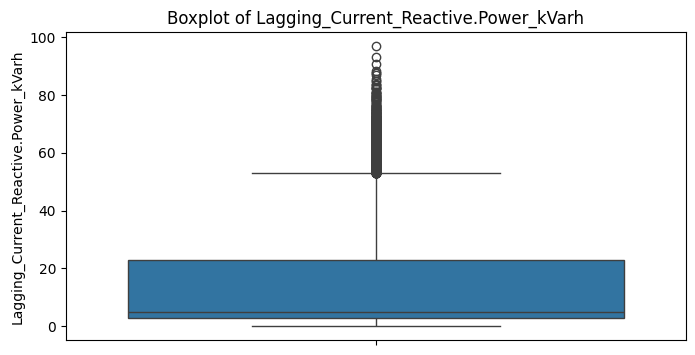

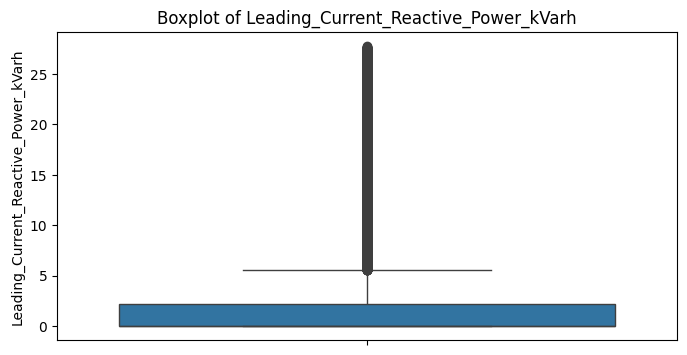

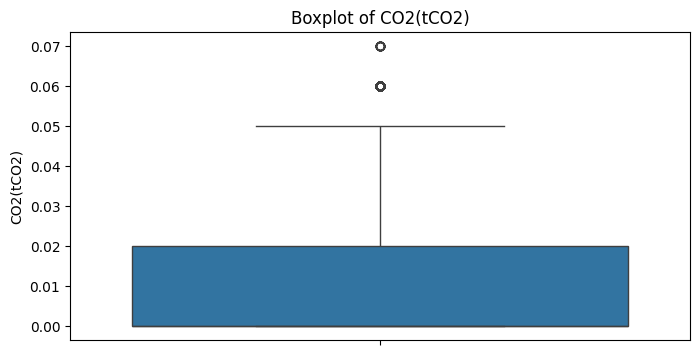

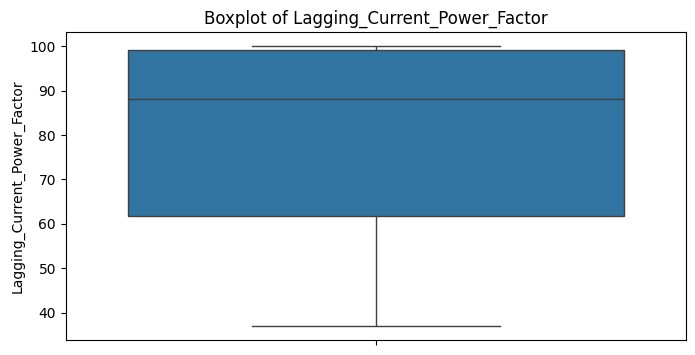

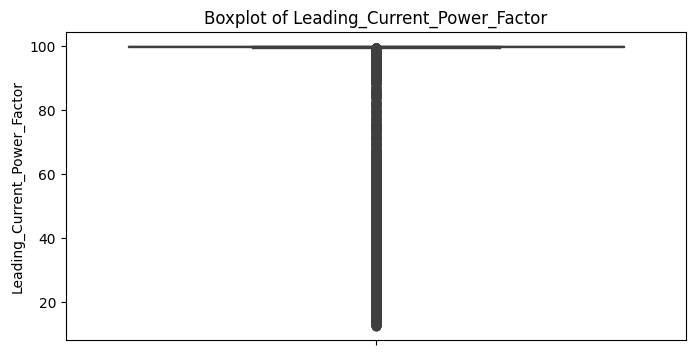

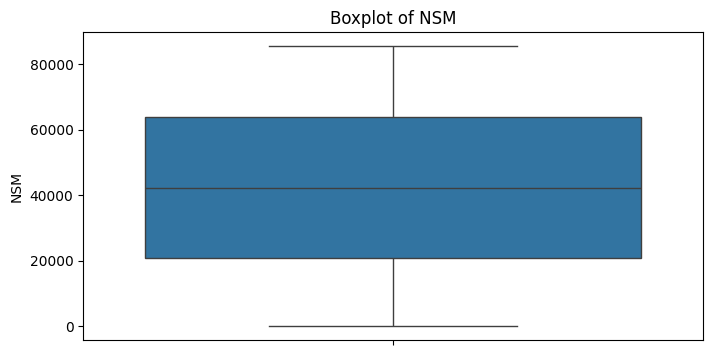

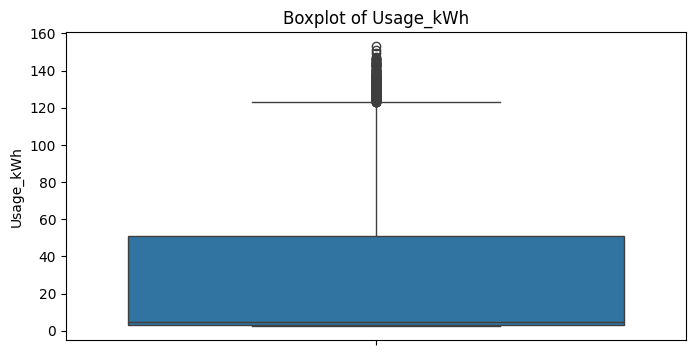

In [58]:
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('Id')

for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

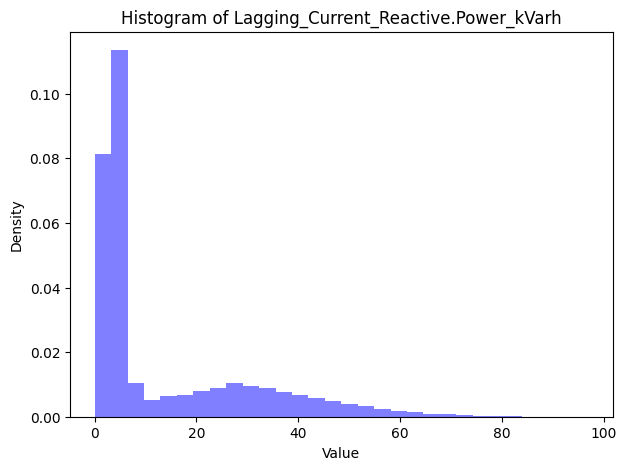

D'Agostino's K^2 Test for Lagging_Current_Reactive.Power_kVarh: p-value = 0.0


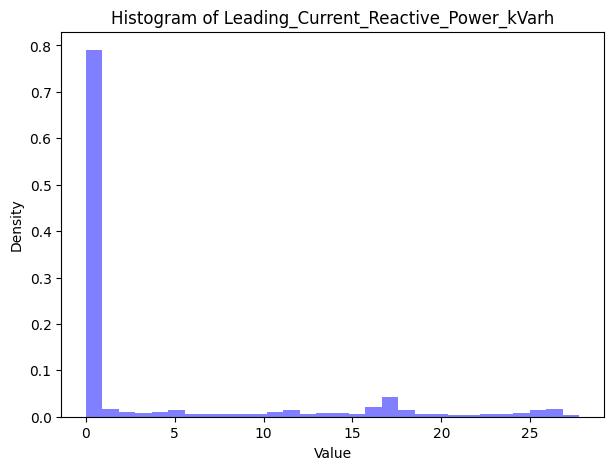

D'Agostino's K^2 Test for Leading_Current_Reactive_Power_kVarh: p-value = nan


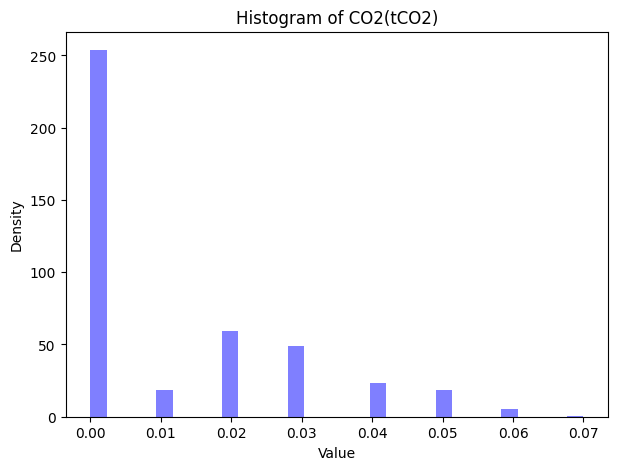

D'Agostino's K^2 Test for CO2(tCO2): p-value = 0.0


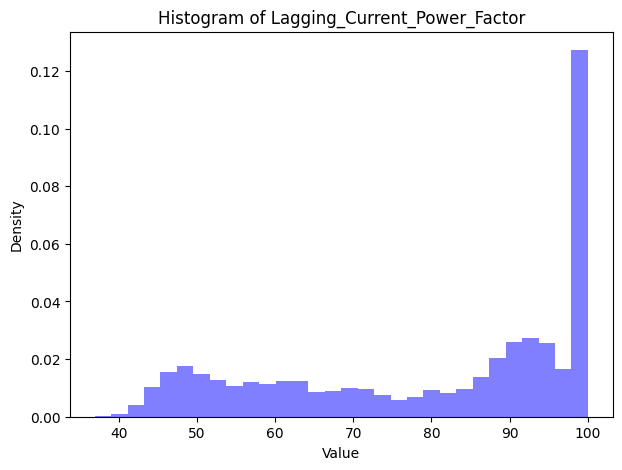

D'Agostino's K^2 Test for Lagging_Current_Power_Factor: p-value = 0.0


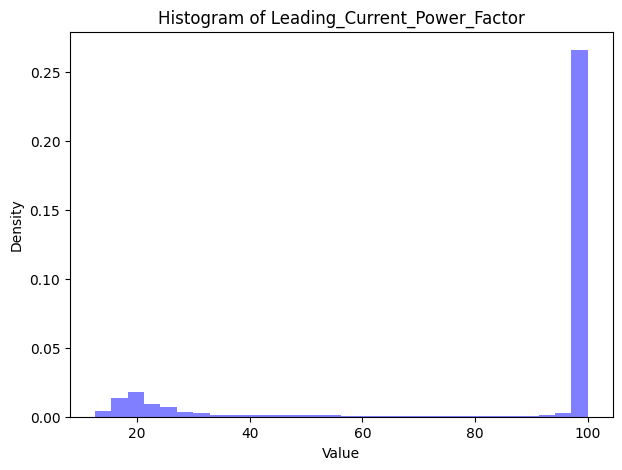

D'Agostino's K^2 Test for Leading_Current_Power_Factor: p-value = nan


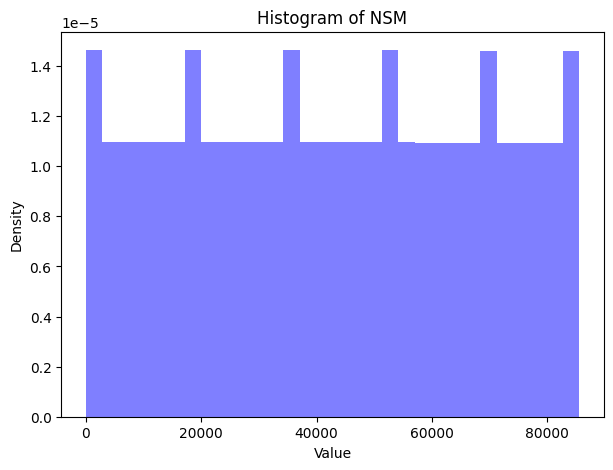

D'Agostino's K^2 Test for NSM: p-value = 0.0


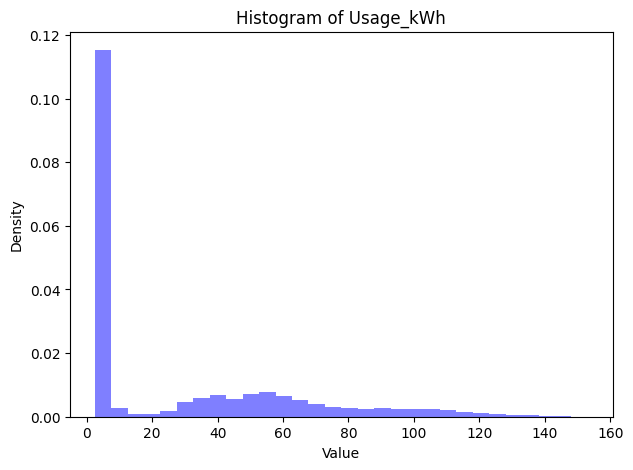

D'Agostino's K^2 Test for Usage_kWh: p-value = 0.0


In [59]:
for column in numerical_columns:
    plt.hist(data[column], bins=30, density=True, alpha=0.5, color='b')
    plt.title('Histogram of {}'.format(column))
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()
    
    normaltest_statistic, normaltest_p_value = stats.normaltest(data[column])
    print(f"D'Agostino's K^2 Test for {column}: p-value = {normaltest_p_value}")


Categorical Columns

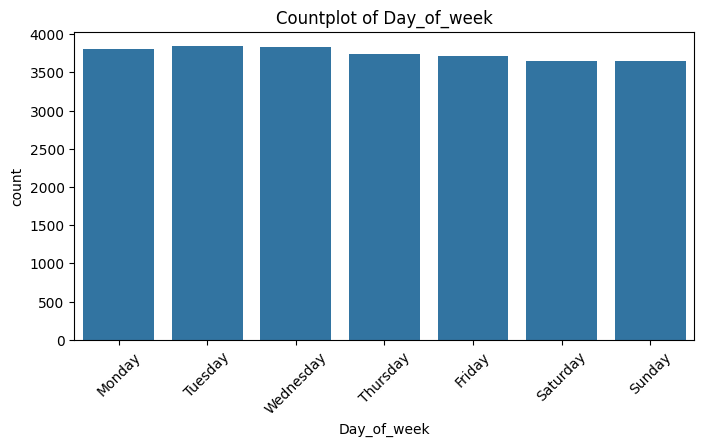

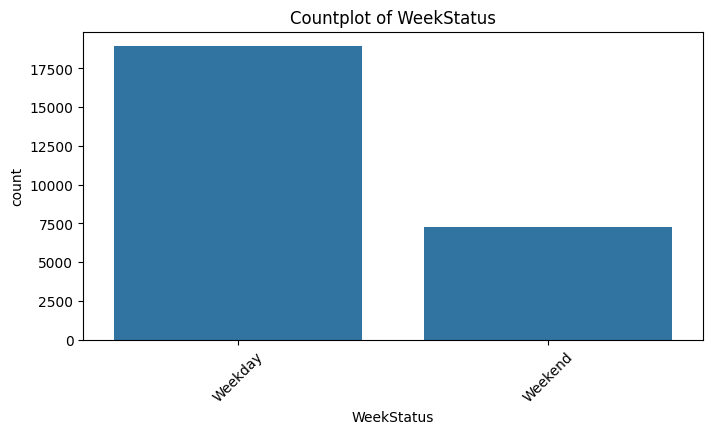

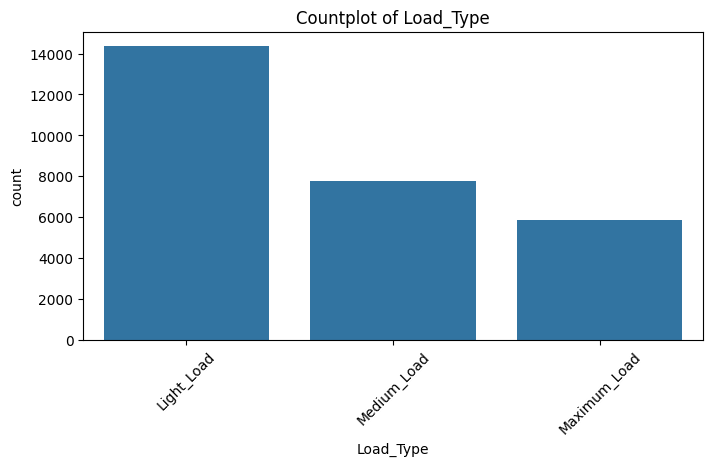

In [60]:
categorical_columns = ['Day_of_week', 'WeekStatus', 'Load_Type']

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=column)
    plt.title(f'Countplot of {column}')
    plt.xticks(rotation=45)
    plt.show()

Data Cleaning

    Handle Missing Values

Dropping Missing Values

In [141]:
data_drop = data.copy()
data_drop = data_drop.dropna(subset=data.columns[1:])
data_drop = data_drop.drop_duplicates()

data_drop.drop(columns='Leading_Current_Reactive_Power_kVarh')

print("Original:", data.shape)
print("After dropping rows with missing values:", data_drop.shape)

Original: (27999, 12)
After dropping rows with missing values: (26030, 12)


Using IQR

In [142]:
Q1 = data_drop.Usage_kWh.quantile(0.25)
Q3 = data_drop.Usage_kWh.quantile(0.75)

IQR = Q3 - Q1

In [143]:
lower_threshold = Q1 - (1.5 * IQR)
upper_threshold = Q3 + (1.5 * IQR)

lower_threshold, upper_threshold

(-69.125, 123.55499999999999)

In [144]:
data_drop[(data_drop.Usage_kWh > lower_threshold)|(data_drop.Usage_kWh < upper_threshold)]

,Id,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Usage_kWh
0,1,1/1/2018 0:15,2.95,0.0,0.00,73.21,100.0,900,Weekday,Monday,Light_Load,3.17
1,2,1/1/2018 0:30,4.46,0.0,0.00,66.77,100.0,1800,Weekday,Monday,Light_Load,4.00
2,3,1/1/2018 0:45,3.28,0.0,0.00,70.28,100.0,2700,Weekday,Monday,Light_Load,3.24
3,4,1/1/2018 1:00,3.56,0.0,0.00,68.09,100.0,3600,Weekday,Monday,Light_Load,3.31
4,5,1/1/2018 1:15,4.50,0.0,0.00,64.72,100.0,4500,Weekday,Monday,Light_Load,3.82
...,...,...,...,...,...,...,...,...,...,...,...,...
27994,27995,19/10/2018 14:45,32.62,0.0,0.02,85.75,100.0,53100,Weekday,Friday,Maximum_Load,54.36
27995,27996,19/10/2018 15:00,35.46,0.0,0.03,84.76,100.0,54000,Weekday,Friday,Maximum_Load,56.63
27996,27997,19/10/2018 15:15,30.92,0.0,0.03,89.63,100.0,54900,Weekday,Friday,Maximum_Load,62.50
27997,27998,19/10/2018 15:30,58.18,0.0,0.04,83.89,100.0,55800,Weekday,Friday,Maximum_Load,89.68


In [145]:
Q1 = data_drop['Lagging_Current_Reactive.Power_kVarh'].quantile(0.25)
Q3 = data_drop['Lagging_Current_Reactive.Power_kVarh'].quantile(0.75)

In [146]:
IQR=Q3-Q1

lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR

lower_limit, upper_limit

(-27.86, 53.739999999999995)

In [147]:
data_drop[(data_drop['Lagging_Current_Reactive.Power_kVarh'] > lower_limit)|(data_drop['Lagging_Current_Reactive.Power_kVarh'] < upper_limit)]

,Id,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Usage_kWh
0,1,1/1/2018 0:15,2.95,0.0,0.00,73.21,100.0,900,Weekday,Monday,Light_Load,3.17
1,2,1/1/2018 0:30,4.46,0.0,0.00,66.77,100.0,1800,Weekday,Monday,Light_Load,4.00
2,3,1/1/2018 0:45,3.28,0.0,0.00,70.28,100.0,2700,Weekday,Monday,Light_Load,3.24
3,4,1/1/2018 1:00,3.56,0.0,0.00,68.09,100.0,3600,Weekday,Monday,Light_Load,3.31
4,5,1/1/2018 1:15,4.50,0.0,0.00,64.72,100.0,4500,Weekday,Monday,Light_Load,3.82
...,...,...,...,...,...,...,...,...,...,...,...,...
27994,27995,19/10/2018 14:45,32.62,0.0,0.02,85.75,100.0,53100,Weekday,Friday,Maximum_Load,54.36
27995,27996,19/10/2018 15:00,35.46,0.0,0.03,84.76,100.0,54000,Weekday,Friday,Maximum_Load,56.63
27996,27997,19/10/2018 15:15,30.92,0.0,0.03,89.63,100.0,54900,Weekday,Friday,Maximum_Load,62.50
27997,27998,19/10/2018 15:30,58.18,0.0,0.04,83.89,100.0,55800,Weekday,Friday,Maximum_Load,89.68


Standardizing the Data

In [148]:
standardized_data = data_drop.copy()
standardized_data['Usage_kWh']=stats.zscore(standardized_data['Usage_kWh'])
standardized_data['Lagging_Current_Reactive_Power.kVarh']=stats.zscore(standardized_data['Lagging_Current_Reactive_Power.kVarh'])
standardized_data['Leading_Current_Reactive_Power_kVarh']=stats.zscore(standardized_data['Leading_Current_Reactive_Power_kVarh'])
standardized_data['CO2']=stats.zscore(standardized_data['CO2'])
standardized_data['Lagging_Current_Power_Factor']=stats.zscore(standardized_data['Lagging_Current_Power_Factor'])
standardized_data['Leading_Current_Power_Factor']=stats.zscore(standardized_data['Leading_Current_Power_Factor'])
standardized_data['NSM']=stats.zscore(standardized_data['NSM'])
standardized_data
standardized_data.to_csv('standard.csv',index=False)

In [149]:
label_encoder = LabelEncoder()
label=label_encoder.fit_transform(standardized_data['WeekStatus'])
standardized_data.drop("WeekStatus",axis=1,inplace=True)
standardized_data["WeekStatus"]=label
standardized_data

,Id,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,Usage_kWh,WeekStatus
0,1,1/1/2018 0:15,-0.631619,-0.515718,-0.727099,-0.339417,0.508518,-1.681947,Monday,Light_Load,-0.735225,0
1,2,1/1/2018 0:30,-0.539796,-0.515718,-0.727099,-0.668189,0.508518,-1.645821,Monday,Light_Load,-0.710691,0
2,3,1/1/2018 0:45,-0.611552,-0.515718,-0.727099,-0.488998,0.508518,-1.609695,Monday,Light_Load,-0.733156,0
3,4,1/1/2018 1:00,-0.594525,-0.515718,-0.727099,-0.600801,0.508518,-1.573568,Monday,Light_Load,-0.731087,0
4,5,1/1/2018 1:15,-0.537364,-0.515718,-0.727099,-0.772844,0.508518,-1.537442,Monday,Light_Load,-0.716012,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27994,27995,19/10/2018 14:45,1.172608,-0.515718,0.498306,0.300768,0.508518,0.413381,Friday,Maximum_Load,0.777914,0
27995,27996,19/10/2018 15:00,1.345308,-0.515718,1.111008,0.250227,0.508518,0.449507,Friday,Maximum_Load,0.845014,0
27996,27997,19/10/2018 15:15,1.069232,-0.515718,1.111008,0.498848,0.508518,0.485634,Friday,Maximum_Load,1.018527,0
27997,27998,19/10/2018 15:30,2.726907,-0.515718,1.723711,0.205813,0.508518,0.521760,Friday,Maximum_Load,1.821948,0


In [150]:
one_hot = pd.get_dummies(standardized_data['Day_of_week'])
standardized_data = standardized_data.drop('Day_of_week',axis = 1)
standardized_data = standardized_data.join(one_hot)
standardized_data

,Id,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type,Usage_kWh,WeekStatus,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,1/1/2018 0:15,-0.631619,-0.515718,-0.727099,-0.339417,0.508518,-1.681947,Light_Load,-0.735225,0,False,True,False,False,False,False,False
1,2,1/1/2018 0:30,-0.539796,-0.515718,-0.727099,-0.668189,0.508518,-1.645821,Light_Load,-0.710691,0,False,True,False,False,False,False,False
2,3,1/1/2018 0:45,-0.611552,-0.515718,-0.727099,-0.488998,0.508518,-1.609695,Light_Load,-0.733156,0,False,True,False,False,False,False,False
3,4,1/1/2018 1:00,-0.594525,-0.515718,-0.727099,-0.600801,0.508518,-1.573568,Light_Load,-0.731087,0,False,True,False,False,False,False,False
4,5,1/1/2018 1:15,-0.537364,-0.515718,-0.727099,-0.772844,0.508518,-1.537442,Light_Load,-0.716012,0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27994,27995,19/10/2018 14:45,1.172608,-0.515718,0.498306,0.300768,0.508518,0.413381,Maximum_Load,0.777914,0,True,False,False,False,False,False,False
27995,27996,19/10/2018 15:00,1.345308,-0.515718,1.111008,0.250227,0.508518,0.449507,Maximum_Load,0.845014,0,True,False,False,False,False,False,False
27996,27997,19/10/2018 15:15,1.069232,-0.515718,1.111008,0.498848,0.508518,0.485634,Maximum_Load,1.018527,0,True,False,False,False,False,False,False
27997,27998,19/10/2018 15:30,2.726907,-0.515718,1.723711,0.205813,0.508518,0.521760,Maximum_Load,1.821948,0,True,False,False,False,False,False,False


In [151]:
one_hot = pd.get_dummies(standardized_data['Load_Type'])
standardized_data = standardized_data.drop('Load_Type',axis = 1)
standardized_data = standardized_data.join(one_hot)

In [156]:
standardized_data = standardized_data.drop(columns='Leading_Current_Reactive_Power_kVarh')
standardized_data.to_csv('standardized.csv',index=False)


Correlation Heat Map

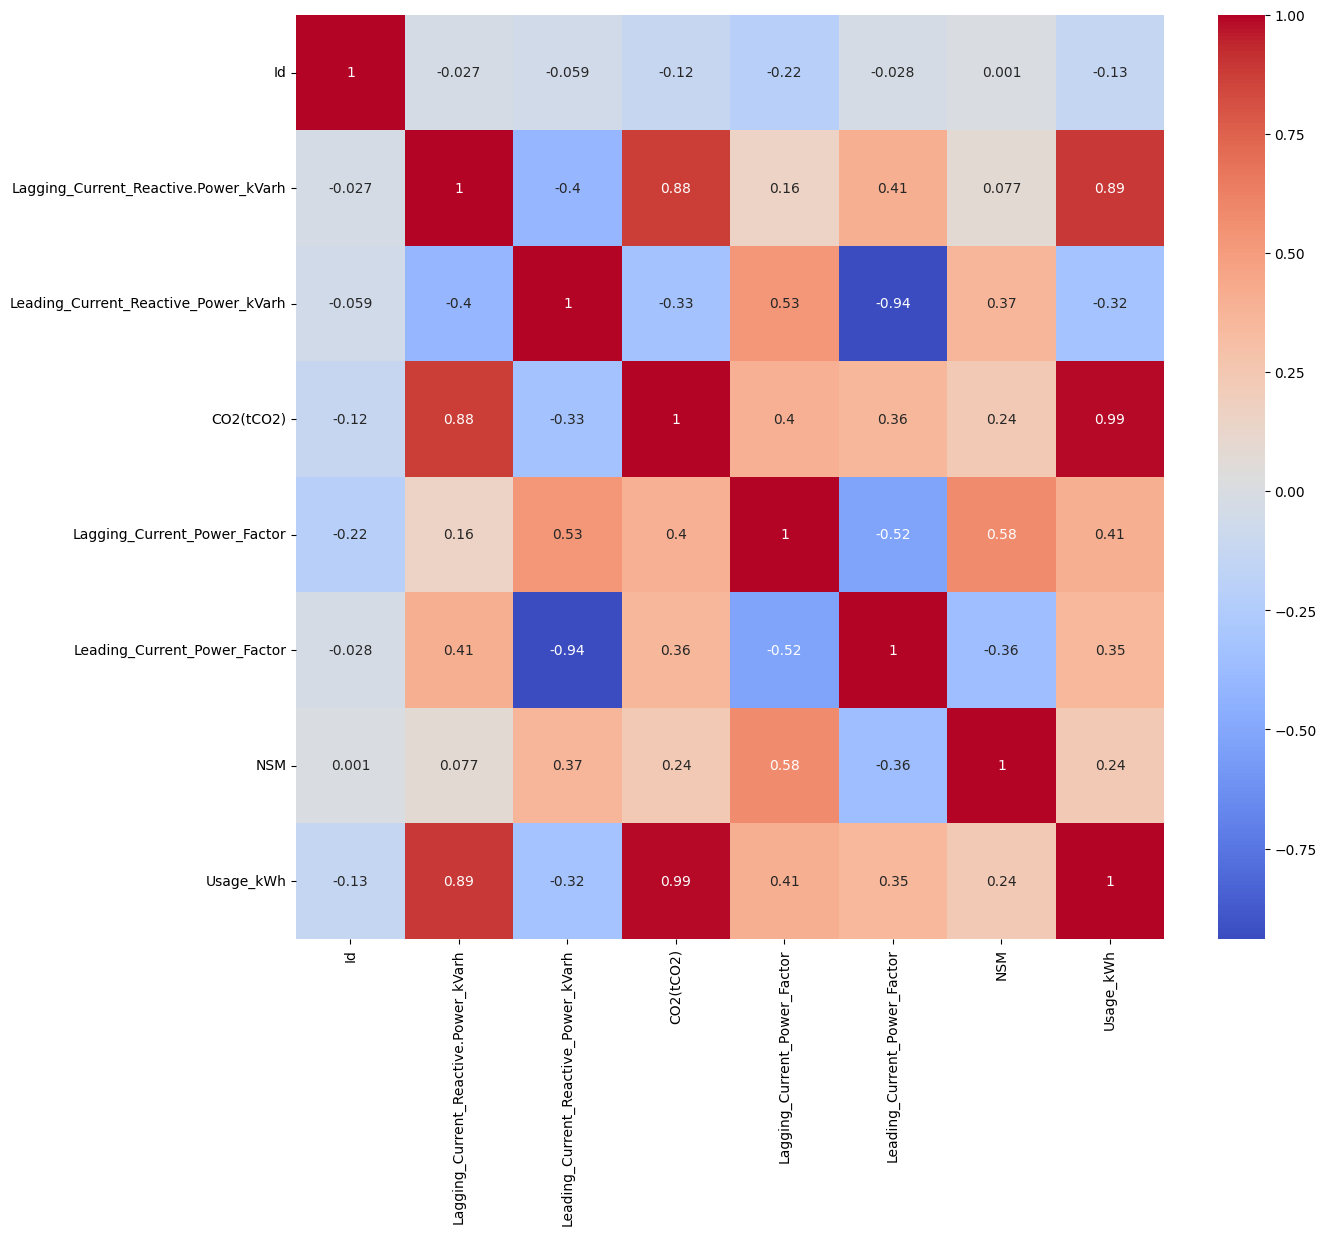

In [157]:
correlation_matrix = data.corr(numeric_only = [False])

plt.figure(figsize = (14,12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.show()

Text(0, 0.5, 'Energy Consumption')

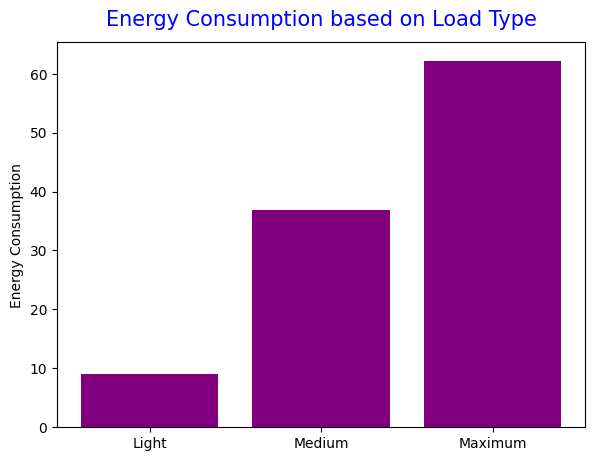

In [74]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1, 2, 1)
usage_chart = data_drop.groupby(['Load_Type'])['Usage_kWh'].mean().sort_values(ascending = True)
labels = ['Light', 'Medium', 'Maximum']
plt.bar(labels, usage_chart.values, color = 'purple')
plt.title('Energy Consumption based on Load Type', fontsize = 15, color = 'b', pad = 12)
plt.ylabel('Energy Consumption')

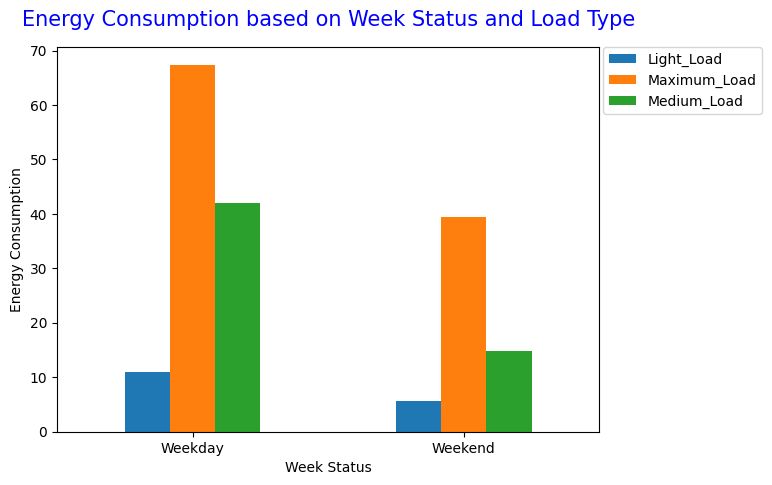

In [75]:
plt.rcParams['figure.figsize'] = (7,5)
chart = data_drop.groupby(['WeekStatus','Load_Type'])['Usage_kWh'].mean().unstack().plot(kind = 'bar')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.title('Energy Consumption based on Week Status and Load Type', fontsize = 15, pad = 15, color = 'b')
plt.xlabel('Week Status')
plt.ylabel('Energy Consumption')
plt.legend(bbox_to_anchor = (1.3, 1), borderaxespad = 0)
plt.show()

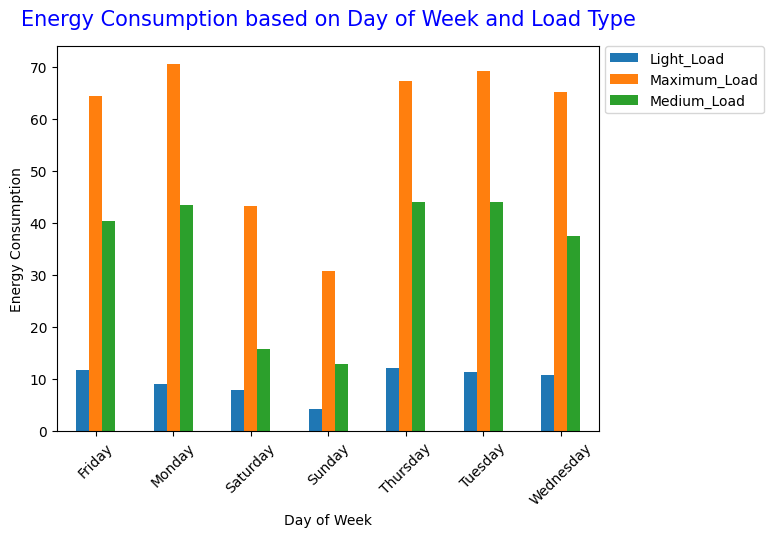

In [76]:
chart = data_drop.groupby(['Day_of_week','Load_Type'])['Usage_kWh'].mean().unstack().plot(kind = 'bar')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('Energy Consumption based on Day of Week and Load Type', fontsize = 15, pad = 15, color = 'b')
plt.xlabel('Day of Week')
plt.ylabel('Energy Consumption')
plt.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)
plt.show()

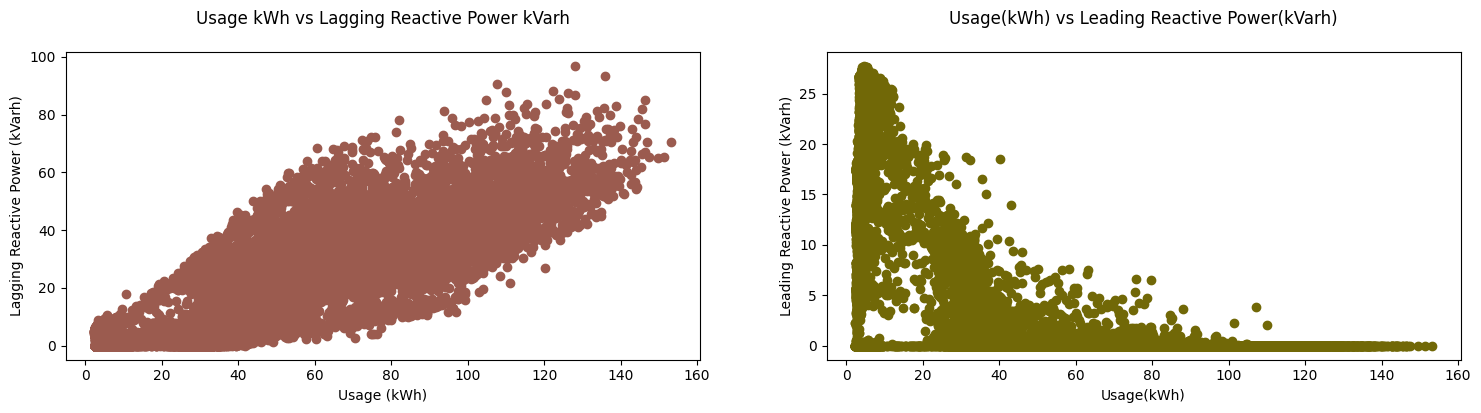

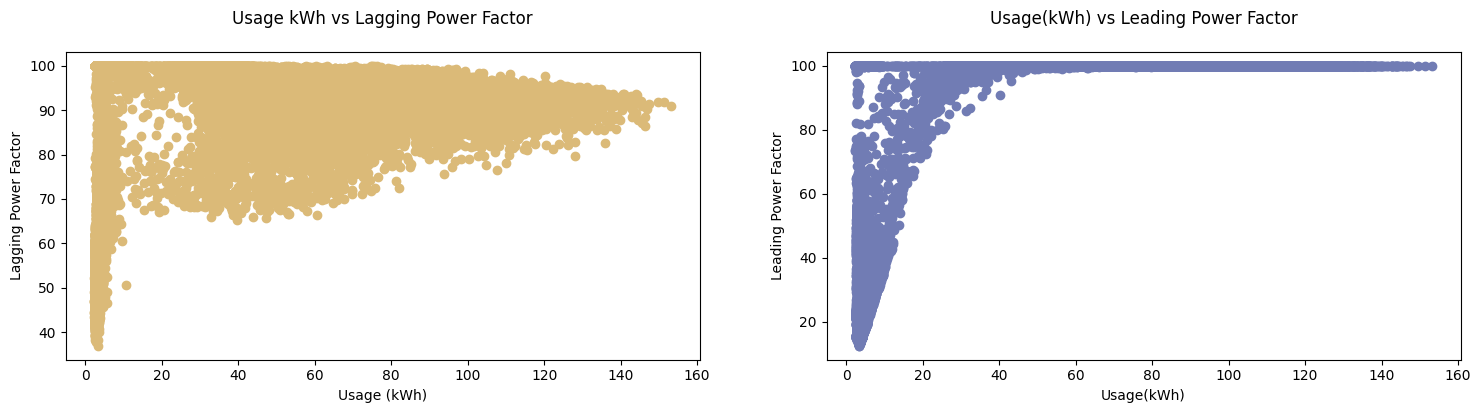

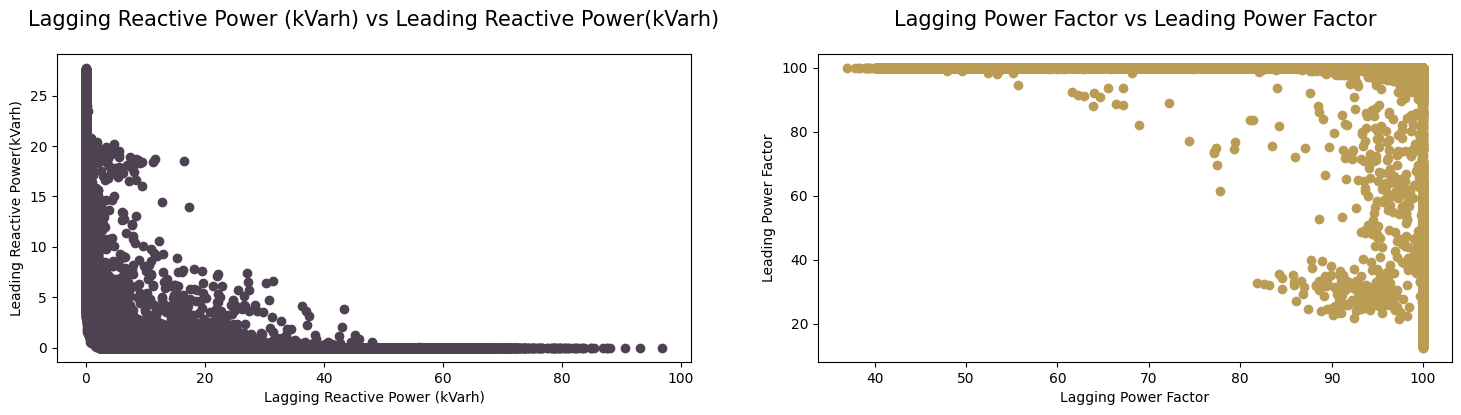

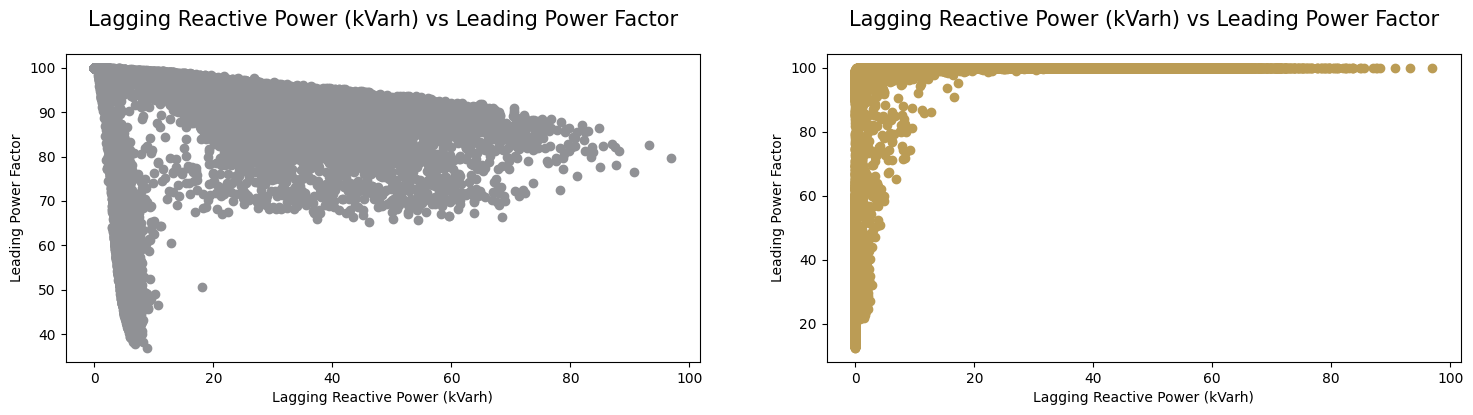

In [77]:
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]

fig, (s1,s2) =plt.subplots(1,2, figsize=(18,4))
fig, (s3,s4) =plt.subplots(1,2, figsize=(18,4))
fig, (s5,s6) =plt.subplots(1,2, figsize=(18,4))
fig, (s7,s8) =plt.subplots(1,2, figsize=(18,4))

s1.scatter(data=data,x="Usage_kWh", y="Lagging_Current_Reactive.Power_kVarh", color=colors[1])
s1.set_title("Usage kWh vs Lagging Reactive Power kVarh",pad=20)
s1.set_xlabel("Usage (kWh)")
s1.set_ylabel("Lagging Reactive Power (kVarh)")

s2.scatter(data=data,x="Usage_kWh",y="Leading_Current_Reactive_Power_kVarh", color=colors[8])
s2.set_title("Usage(kWh) vs Leading Reactive Power(kVarh)",pad=20)
s2.set_xlabel("Usage(kWh)")
s2.set_ylabel("Leading Reactive Power (kVarh)")

s3.scatter(data=data,x="Usage_kWh", y="Lagging_Current_Power_Factor", color=colors[3])
s3.set_title("Usage kWh vs Lagging Power Factor",pad=20)
s3.set_xlabel("Usage (kWh)")
s3.set_ylabel("Lagging Power Factor")

s4.scatter(data=data,x="Usage_kWh",y="Leading_Current_Power_Factor", color=colors[9]) 
s4.set_title("Usage(kWh) vs Leading Power Factor",pad=20)
s4.set_xlabel("Usage(kWh)")
s4.set_ylabel("Leading Power Factor")

s5.scatter(data=data,x="Lagging_Current_Reactive.Power_kVarh",y="Leading_Current_Reactive_Power_kVarh", color=colors[2]) 
s5.set_title("Lagging Reactive Power (kVarh) vs Leading Reactive Power(kVarh)",pad=20,fontsize=15)
s5.set_xlabel("Lagging Reactive Power (kVarh)")
s5.set_ylabel("Leading Reactive Power(kVarh)")

s6.scatter(data=data,x="Lagging_Current_Power_Factor",y="Leading_Current_Power_Factor", color=colors[4]) 
s6.set_title("Lagging Power Factor vs Leading Power Factor",pad=20,fontsize=15)
s6.set_xlabel("Lagging Power Factor")
s6.set_ylabel("Leading Power Factor")

s7.scatter(data=data,x="Lagging_Current_Reactive.Power_kVarh",y="Lagging_Current_Power_Factor", color=colors[5]) 
s7.set_title("Lagging Reactive Power (kVarh) vs Leading Power Factor",pad=20,fontsize=15)
s7.set_xlabel("Lagging Reactive Power (kVarh)")
s7.set_ylabel("Leading Power Factor")

s8.scatter(data=data,x="Lagging_Current_Reactive.Power_kVarh",y="Leading_Current_Power_Factor", color=colors[4]) 
s8.set_title("Lagging Reactive Power (kVarh) vs Leading Power Factor",pad=20,fontsize=15)
s8.set_xlabel("Lagging Reactive Power (kVarh)")
s8.set_ylabel("Leading Power Factor")

plt.show()

Pre Modeling

In [78]:
train_data = standardized_data.set_index('date')

In [83]:
train_data.drop(columns='Id')

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh,WeekStatus,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Load,Maximum_Load,Medium_Load
date,,,,,,,,,,,,,,,,,,
1/1/2018 0:15,-0.631619,-0.515718,-0.727099,-0.339417,0.508518,-1.681947,-0.735225,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:30,-0.539796,-0.515718,-0.727099,-0.668189,0.508518,-1.645821,-0.710691,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:45,-0.611552,-0.515718,-0.727099,-0.488998,0.508518,-1.609695,-0.733156,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:00,-0.594525,-0.515718,-0.727099,-0.600801,0.508518,-1.573568,-0.731087,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:15,-0.537364,-0.515718,-0.727099,-0.772844,0.508518,-1.537442,-0.716012,0,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19/10/2018 14:45,1.172608,-0.515718,0.498306,0.300768,0.508518,0.413381,0.777914,0,True,False,False,False,False,False,False,False,True,False
19/10/2018 15:00,1.345308,-0.515718,1.111008,0.250227,0.508518,0.449507,0.845014,0,True,False,False,False,False,False,False,False,True,False
19/10/2018 15:15,1.069232,-0.515718,1.111008,0.498848,0.508518,0.485634,1.018527,0,True,False,False,False,False,False,False,False,True,False


In [190]:
X = train_data.drop(columns='Usage_kWh')
y = train_data['Usage_kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (14576, 18)
Validation set shape: (3645, 18)
Test set shape: (7809, 18)


,Id,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh,WeekStatus,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Load,Maximum_Load,Medium_Load
date,,,,,,,,,,,,,,,,,,,
1/1/2018 0:15,1,-0.631619,-0.515718,-0.727099,-0.339417,0.508518,-1.681947,-0.735225,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:30,2,-0.539796,-0.515718,-0.727099,-0.668189,0.508518,-1.645821,-0.710691,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:45,3,-0.611552,-0.515718,-0.727099,-0.488998,0.508518,-1.609695,-0.733156,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:00,4,-0.594525,-0.515718,-0.727099,-0.600801,0.508518,-1.573568,-0.731087,0,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:15,5,-0.537364,-0.515718,-0.727099,-0.772844,0.508518,-1.537442,-0.716012,0,False,True,False,False,False,False,False,True,False,False


In [158]:
#Linear Regression Model
lr = LinearRegression()
%time lr.fit(X_train, y_train)
lr.score(X_test, y_test)

CPU times: total: 0 ns
Wall time: 8.98 ms


0.9817024459400486

In [ ]:
pipeline = make_pipeline(PolynomialFeatures(), Ridge())

param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'ridge__alpha': [0.01, 0.1, 1, 10]
}
scorer = make_scorer(r2_score)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)

%time grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best R^2 score:", best_score)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test R^2 score with best model:", test_score)



In [169]:
#Lasso Regression Model
lasso = Lasso(alpha = 0.5)
%time lasso.fit(X_train , y_train)
lasso.score(X_test, y_test)

CPU times: total: 15.6 ms
Wall time: 18.9 ms


0.7233917193075152

In [214]:
degree = 3

model_poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model_poly, X_train, y_train, cv=k_fold, scoring='r2')

print("Polynomial Regression Cross-Validation Scores (R^2):", cv_scores)

mean_r2 = cv_scores.mean()
print("Mean Polynomial Regression Cross-Validation Score (R^2):", mean_r2)

poly_features = model_poly.named_steps['polynomialfeatures']
linear_regression_model = model_poly.named_steps['linearregression']

Polynomial Regression Cross-Validation Scores (R^2): [0.99844351 0.99690369 0.99809671 0.99647681 0.99811667]
Mean Polynomial Regression Cross-Validation Score (R^2): 0.9976074802633154


In [91]:
#prediction
y_pred = lr.predict(X_test)
print(y_pred)

[-0.78392838 -0.74472656 -0.74473886 ... -0.73573646 -0.79059324
 -0.77516591]


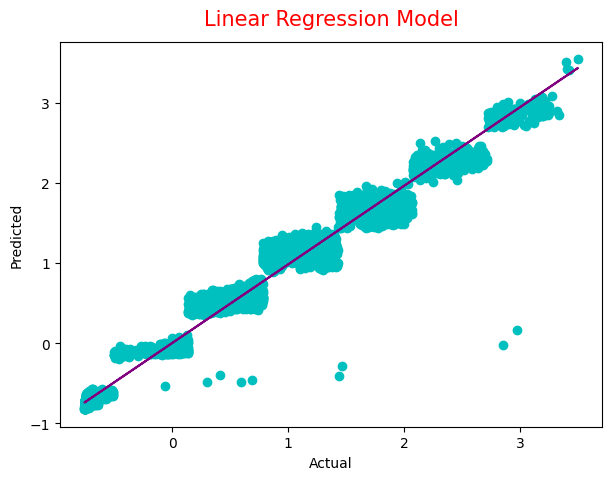

In [92]:
#visualize model
x = y_test
y = y_pred

plt.title('Linear Regression Model', fontsize = 15, color = 'red', pad = 12)
plt.plot(x, y, 'o', color = 'c')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color = 'purple')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [93]:
#Mean absolute error for lr model 
mean_absolute_error(y_test, y_pred)

0.08315143869508845

In [94]:
# R-Squared for lr model 
r2_score(y_test,y_pred)

0.9815231581530919

In [95]:
#RMSE for lr model 
mean_squared_error(y_test, y_pred)

0.018221211182722668

In [97]:
#evaluation of ridge_regression with MAE
y_pred_ridge = ridge.predict(X_test)
mean_absolute_error(y_test, y_pred_ridge)

0.08316351613538821

In [106]:
#evaluation of ridge_regression with RMSE
mean_squared_error(y_test, y_pred_ridge)

0.018223077674837874

In [107]:
#evaluation of ridge_regression with  R-squared
r2_score(y_test,y_pred_ridge)

0.9815212654754166

In [100]:
#evaluation of lasso_regression with MAE
y_pred_lasso = lasso.predict(X_test)
mean_absolute_error(y_test, y_pred_lasso)

0.4373114467260974

In [101]:
#evaluation of lasso_regression with RMSE
mean_squared_error(y_test, y_pred_lasso)

0.27137358399342093

Prediciting Test Values

In [215]:
test_data = pd.read_csv('data/test.csv')
test_data = test_data.set_index('date')

label_encoder = LabelEncoder()
label = label_encoder.fit_transform(test_data['WeekStatus'])
test_data.drop("WeekStatus", axis=1, inplace=True)
test_data["WeekStatus"] = label

one_hot = pd.get_dummies(test_data['Day_of_week'])
test_data = test_data.drop('Day_of_week', axis=1)
test_data = test_data.join(one_hot)

one_hot = pd.get_dummies(test_data['Load_Type'])
test_data = test_data.drop('Load_Type', axis=1)
test_data = test_data.join(one_hot)

test_data['Lagging_Current_Reactive.Power_kVarh'] = stats.zscore(test_data['Lagging_Current_Reactive.Power_kVarh'])
test_data['Leading_Current_Reactive_Power_kVarh'] = stats.zscore(test_data['Leading_Current_Reactive_Power_kVarh'])
test_data['CO2(tCO2)'] = stats.zscore(test_data['CO2(tCO2)'])
test_data['Lagging_Current_Power_Factor'] = stats.zscore(test_data['Lagging_Current_Power_Factor'])
test_data['Leading_Current_Power_Factor'] = stats.zscore(test_data['Leading_Current_Power_Factor'])
test_data['NSM'] = stats.zscore(test_data['NSM'])

X_test = test_data

X_test_poly = poly_features.transform(X_test)

y_pred_test = linear_regression_model.predict(X_test_poly)



NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.